### 서론

클러스터링은 매우 어려운 문제인데, 그 이유는 레이블이 알려지지 않은 경우에는 진정한 '정답'이란 것이 존재하지 않기 때문이다.

더 복잡하게 만드는 요인으로는, 클러스터링 알고리즘에는 **No Free Lunch(무료 점심은 없다)** 법칙이 적용된다는 점이 있다. 즉, 어떤 알고리즘이 특정 데이터셋에서는 잘 작동할 수 있지만, 다른 데이터에서는 동일하게 잘 작동할 것이라는 보장이 없다는 뜻이다. 마찬가지로, 클러스터링은 \*"연구자의 맥락, 목표, 그리고 판단에 강하게 의존한다"\*는 점도 이 주장의 근거가 된다. 그래서 \*"자연스러운 군집을 무조건 잘 찾아주는 보편적인 최적 방법이란 건 없다"\*는 논란에 불을 붙인다(자세한 내용은 [What Are True Clusters? Henning 2015](https://arxiv.org/abs/1502.02555) 참고).

게다가, KMeans와 같이 일반적으로 잘 쓰이는 클러스터링 기법들은 데이터가 **수치형이고, 구(sphere) 형태의 분포**를 가진다는 전제를 깔고 있다. 그러나 데이터가 혼합형(수치형+범주형)이고, 차원 수가 많아지면, 차원 축소 기법인 PCA(주성분 분석)처럼 고전적인 방법들은 범주형 데이터가 포함된 경우에는 제대로 동작하지 않는다. 그래서 실무자는 어떤 특성 추출 방식을 적용해야 할지 딜레마에 빠지게 되는데, 예를 들어 수치형 변수만 남기거나, 모든 데이터를 범주형으로 변환해서 MCA(다중 대응분석) 같은 방법을 쓰는 식의 접근이 필요해진다.

여기서 제안하는 방법은 기본값처럼 쓸 수 있는 클러스터링 알고리즘을 찾는 어려움과, 데이터가 혼합형일 때 생기는 여러 문제를 동시에 해결하고자 한다. [UMAP(Uniform Manifold Approximation and Projection)](https://arxiv.org/abs/1802.03426)과 [HDBSCAN(Hierarchical Density Based Clustering)](https://arxiv.org/abs/1705.07321)을 조합해서, 먼저 혼합형 데이터를 조밀하고 낮은 차원의 공간으로 사상(embedding)한 다음, 이 임베딩 공간에서 점들의 밀도에 따라 계층적으로 클러스터링한다. 최종 결과는, 다양한 데이터에 적용 가능한 간단한 end-to-end 솔루션을 제공하여, 의미 있는 클러스터를 찾는 데 도움을 준다.


In [1]:
%pip install matplotlib seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing

from denseclus import DenseClus

%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

In [3]:
SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url).sample(n=2000, random_state=SEED)

In this example, you will use a synthetic churn dataset for an imaginary telecommunications company with the outcome Churn? flagged as as either True (churned) or False (did not churn). Features include customer details such as plan and usage information. The churn dataset is publicly available and mentioned in the book [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/). It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

In [4]:
df.drop(["Phone", "Area Code"], axis=1, inplace=True)
df.dtypes

State              object
Account Length      int64
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting a groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

In [14]:
hdbscan_params = {"cluster_selection_method": "leaf",
                  "min_cluster_size": 100}

clf = DenseClus(
    random_state=SEED,
    umap_combine_method="intersection_union_mapper",
    hdbscan_params=hdbscan_params,
)

clf.fit(df)

Max of 51 is greater than threshold 25
Hashing categorical features


As a recap the steps that happened are:

1). Numerical features were taken out and then reduced into a *dense* UMAP embedding

2) Categorical features got extracted and learned into a *dense* separate UMAP embedding

3) The two embeddings were then combined with an intersection over union operation

4) HDBSCAN uses density-based spatial clustering to hierarchical-fashion to extract clusters from the combined space

All of these features are now attached as usable `DenseClus` object. 

## Checking Embedding Results

Verify the embeddings are now densely shaped.

In [15]:
for i in range(clf.mapper_.embedding_.shape[1]):
    sns.kdeplot(clf.mapper_.embedding_[:, i], shade=True)

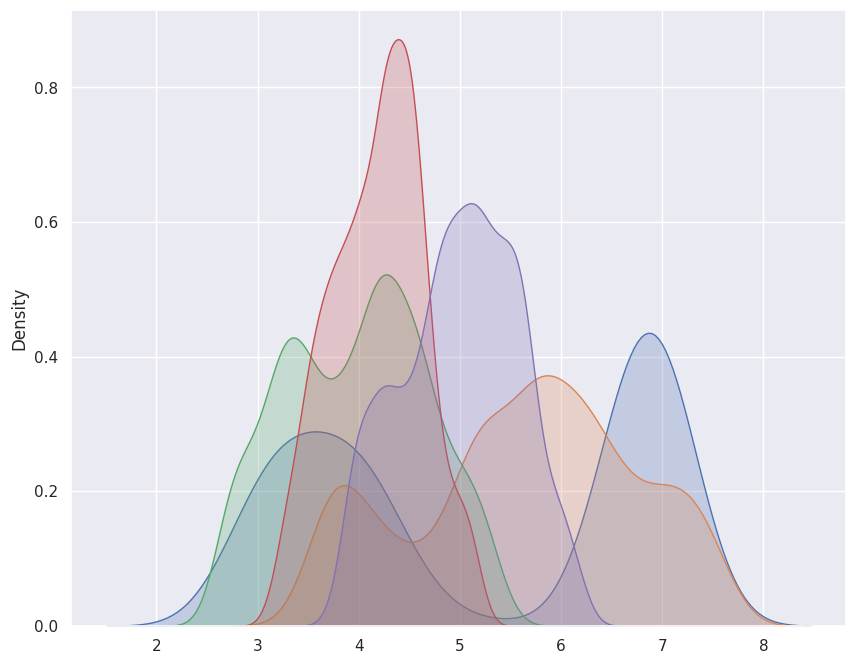

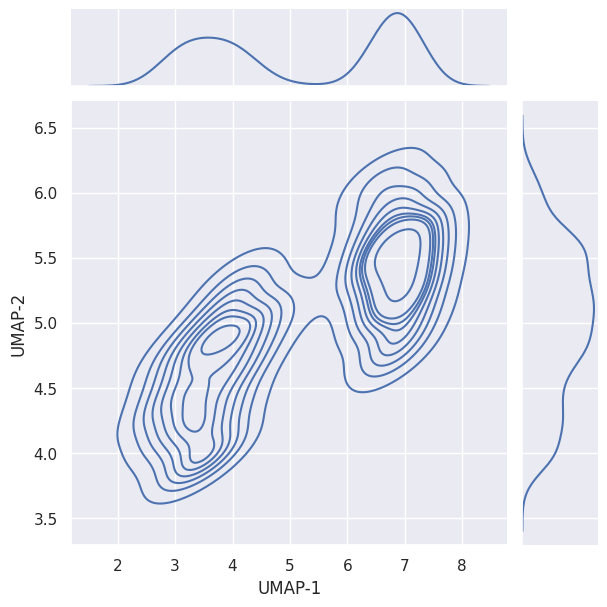

In [16]:
g = sns.jointplot(x=clf.mapper_.embedding_[:, 0], y=clf.mapper_.embedding_[:, -1], kind="kde")

g.set_axis_labels("UMAP-1", "UMAP-2")

plt.show()

# Inspection of Cluster Results

The clustering results are extricable from the object.

X groups formed into clusters, with the largest constituting Y% of the data.

In [17]:
labels = clf.evaluate()

print(labels, "\n")
print(pd.DataFrame(labels).value_counts(normalize=True))

Coverage 0.631
Calinski-Harabasz Score: 904.9152106616983
[ 2  1 -1 ...  2  1  1] 

0 
-1    0.3690
 1    0.1765
 2    0.1570
 0    0.1555
 3    0.1420
Name: proportion, dtype: float64


Just like with DBSCAN, labels of -1 are flagged as noise and all lables have an associated noise probability score.

In practice, these can be thrown out or put into an 'other' cluster.

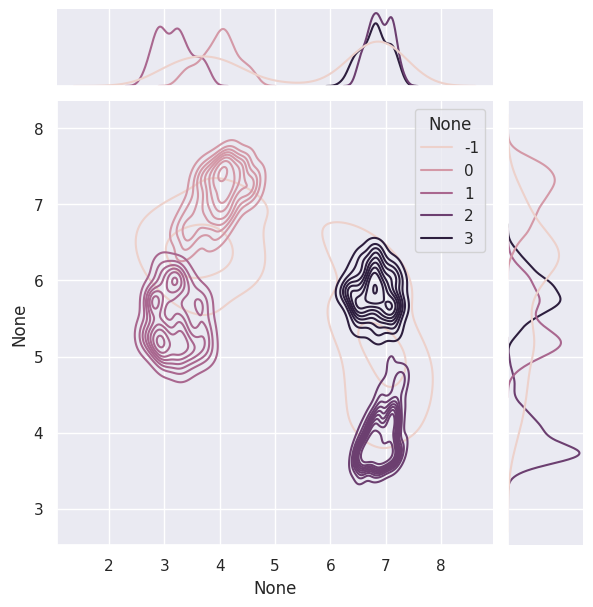

In [18]:
_ = sns.jointplot(
    x=clf.mapper_.embedding_[:, 0],
    y=clf.mapper_.embedding_[:, 1],
    hue=labels,
    kind="kde",
)

plt.show()

As you can see above, the clusters formed based on the densities represented in the reduced space.

Specifically, 4 groups got identified by the data.

Since HDBSCAN is hierarchical in nature and splits based on a tree.

Instead of using the default method, you used `leaf` which splits into smaller groups along the tree. 

The below plot shows that the default setting would find two clusters total but since we split along the leaf there are four.

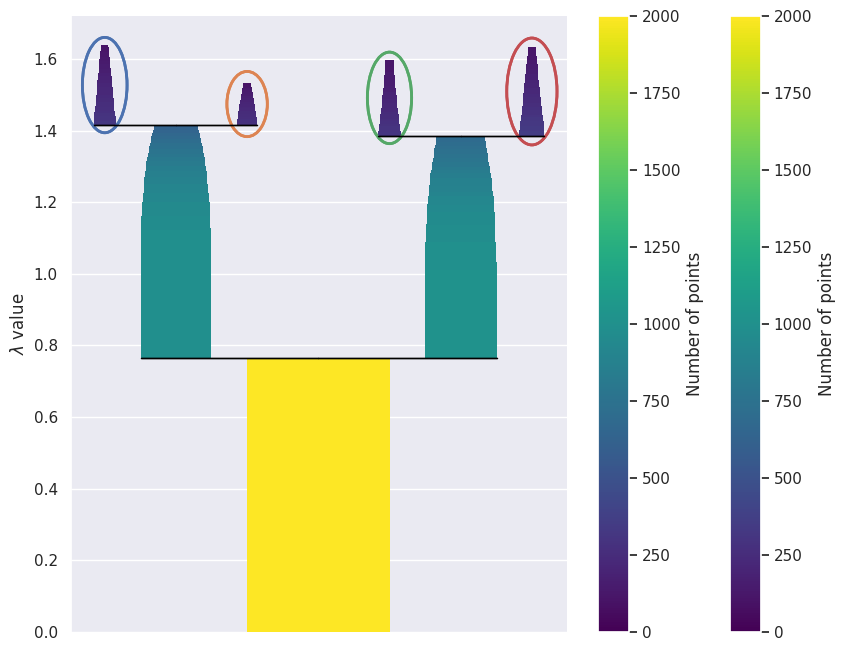

In [20]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(labels).shape[0]),
)

plt.show()

# Profiling the Clusters

Finally, once clusters are formed, it's common practice to then describe what each one means.

Here, descriptive statistics is actually a very powerful (and efficient) tool to use.

In [21]:
df["segment"] = clf.evaluate()

numerics = df.select_dtypes(include=[int, float]).drop(labels=["segment"], axis=1).columns.tolist()

df[numerics + ["segment"]].groupby(["segment"]).median()

Coverage 0.631
Calinski-Harabasz Score: 904.9152106616983


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
segment,,,,,,,,,,,,,,,
-1,99.5,100.0,5.786438,3.0,5.858333,5.664846,3.0,5.078639,4.172144,250.0,5.588207,5.099899,5.0,4.313531,6.0
0,103.0,0.0,8.634997,4.0,6.112037,6.490774,2.0,6.844671,4.118484,150.0,6.147895,5.004105,6.0,5.474335,5.0
1,107.0,0.0,2.340252,4.0,3.754096,3.776264,4.0,3.482277,3.775256,300.0,3.501818,5.010975,6.0,3.743266,5.0
2,108.0,500.0,1.875579,4.0,3.563110,3.584235,4.0,3.330765,3.763520,300.0,3.719664,4.968563,5.0,3.905956,5.0
3,91.0,400.0,7.201899,4.0,5.679513,5.665423,2.0,5.915301,4.123792,150.0,6.261674,5.075457,6.0,4.114574,6.0


Let's ignore group `-1`.

You can see that only first segment `0` has the shortest day minutes and high night calls. These are perhaps customers that prefer calling (and getting called) in the night.

The second segment `1` has the highest day minutes and day charges. These are customer that prefer calling (and getting called) during the day.

This type of profiling is possible with the other segments as well, coming up with a description of what attributes they constitute and how they relate to your objective.

Again, this is just profiling but descriptive statistics are revealing of what patterns are captured.

A similar type of analysis is possible with categorical features, with a reference shown below.

In [22]:
categorical = df.select_dtypes(include=["object"]).drop(labels=["State"], axis=1)

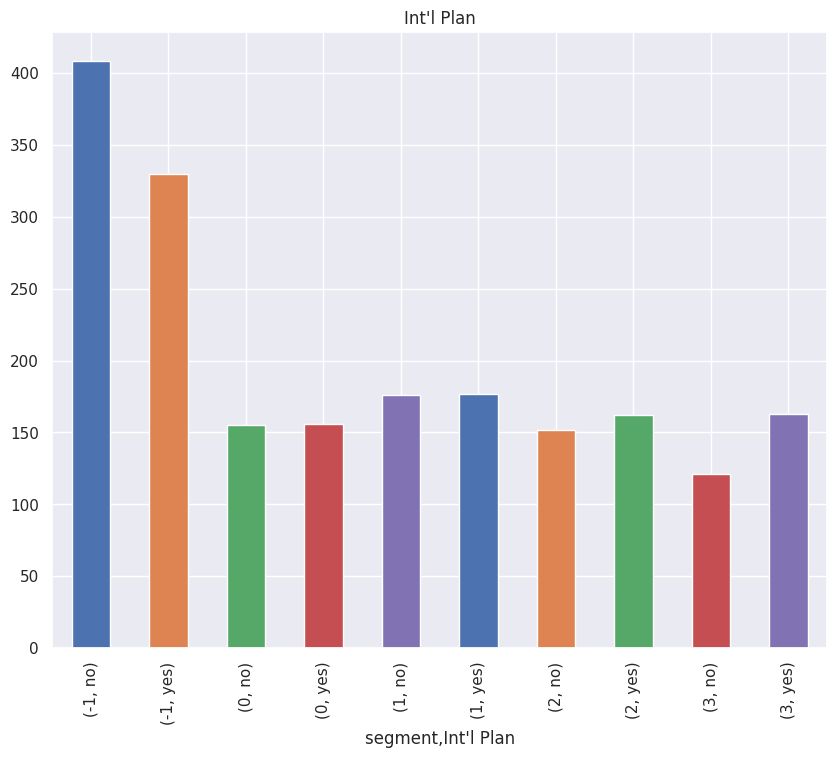

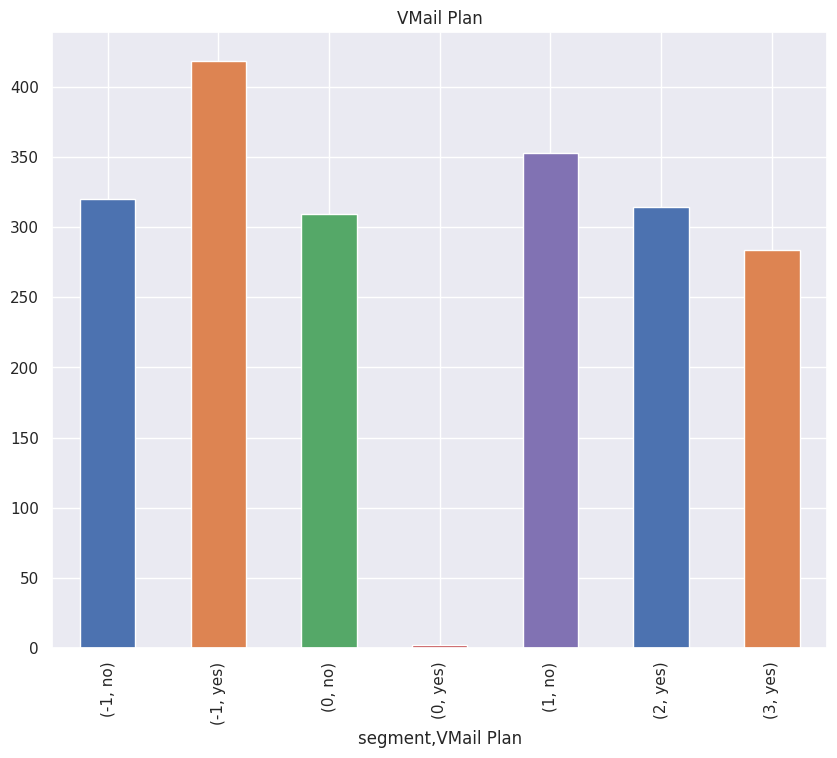

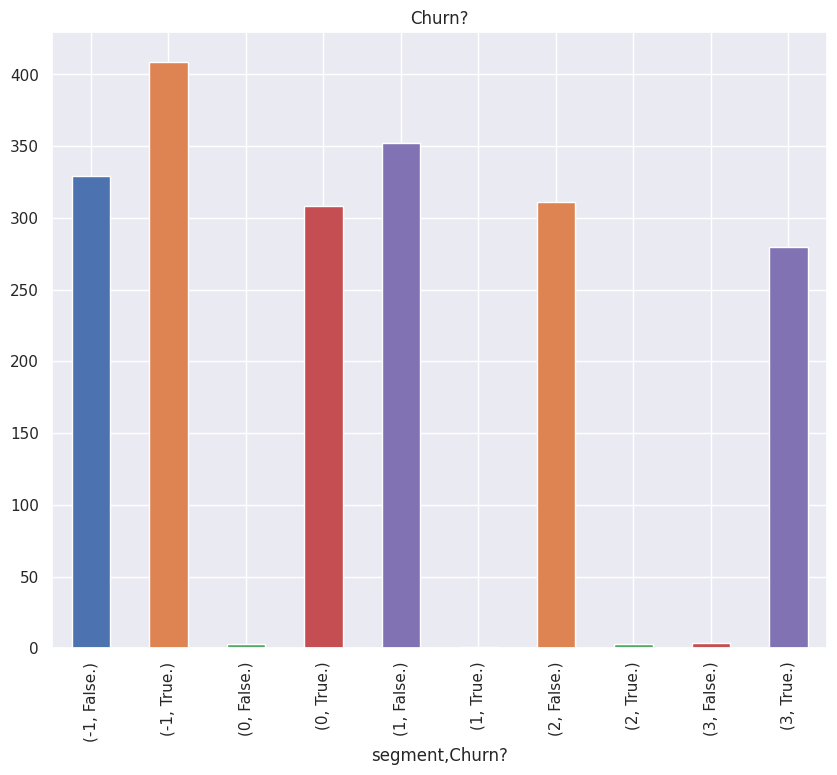

In [23]:
for c in categorical.columns:
    df.groupby(["segment"] + [c]).size().plot(
        kind="bar", color=sns.color_palette("deep", np.unique(labels).shape[0])
    )
    plt.title(c)
    plt.show()